# KNN Model Training Notebook

This Jupyter Notebook serves as a documentation and workflow for training the K-Nearest Neighbors (KNN) model. The KNN algorithm is a classification algorithm that is based on the concept of finding the k nearest neighbors to a given data point and classifying it based on the majority class of its neighbors.

## Data Processing

In the following cells, we import the necessary libraries and load the training and testing datasets. There are 2 variables that can be changed depending on the kind of dataset we want :
* `withOutliers` : True or False
* `data` : 'normal' | 'oversampled' | 'undersampled' 

NOTE : Make sure you already made the datasets with the commands:
- `make data`
- `make features`

We also perform data preprocessing steps such as encoding labels. Other preprocessing steps such as removing correlations with pca, and scaling the data are done within the pipeline of the model.



In [1]:
""" Import libraries """
import pandas as pd
import numpy as np
from src.models.KNNClassifier import KNNClassifier
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set the kind of data to use
withOutliers = False
data = 'undersampled' 

o = {True: "with", False: "without"}
d = {'normal': "", 'oversampled': "_over", 'undersampled': "_under"}

# Load train and test split
X_train = pd.read_csv(f'../data/processed/{o[withOutliers]}_outliers/train{d[data]}.csv')
y_train = X_train['class']
X_train = X_train.drop(['class'], axis=1)
X_test = pd.read_csv(f'../data/processed/{o[withOutliers]}_outliers/test.csv')
y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

## Model Training

Once the data is processed, we proceed to train the KNN model using hyperparameter tuning and cross validation to optimize performance. We use a [random search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) which is more efficient than a grid-search.

F1 score is choosen as the evaluation metric considering the scenarios where we use unbalanced data. F1 score provides a balance between precision and recall.

For more detail about the influence of each parameter. Please refer to the [sklearn website](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [3]:
# Create the model
clf = KNNClassifier()

# Choose the hyperparameters search space
parameters = {'n_neighbors': sp_randint(1, 40),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'weights': ['uniform', 'distance'],
              'p': sp_randint(1, 3),
              'leaf_size': sp_randint(10, 100),
              'n_jobs': [3]
              }

# Perform the hyperparameter tuning with cross validation
clf.hyperparameter_tuning(X_train,y_train,parameters,search_type='random',cv=3,scoring='f1_macro',n_iteration=400)

In [7]:
print(f'Best parameters: {clf.best_params}')

Best parameters: {'model__algorithm': 'kd_tree', 'model__leaf_size': 24, 'model__n_jobs': 3, 'model__n_neighbors': 6, 'model__p': 1, 'model__weights': 'distance'}


## Model Evaluation

After training the model, we evaluate its performance using the processed testing data. We calculate various evaluation metrics such as accuracy, precision, recall, and F1-score to assess the model's performance.

We also display the confusion matrix and the ROC curve.


Inference time : 4.216620077689489e-05 seconds
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     11621
           1       0.93      0.94      0.94      3740
           2       0.90      0.99      0.94      3839

    accuracy                           0.95     19200
   macro avg       0.94      0.96      0.95     19200
weighted avg       0.96      0.95      0.95     19200

auc score for class 0:  0.9802924270966022
auc score for class 1:  0.9824156699019723
auc score for class 2:  0.9924054972963859


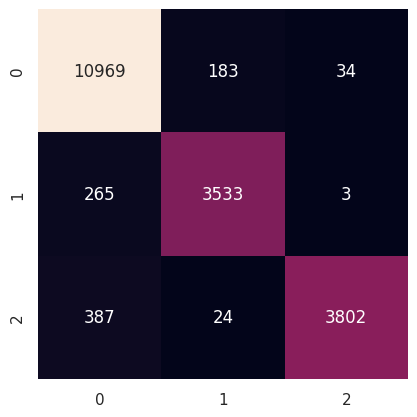

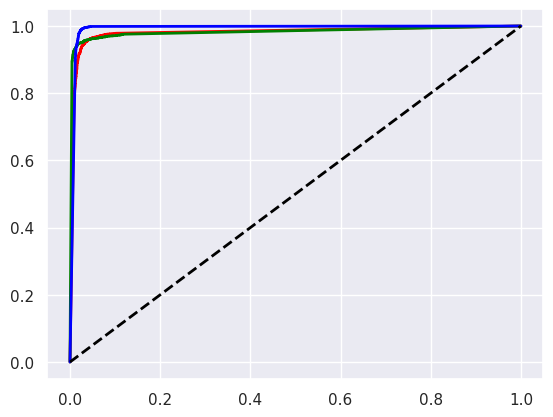

In [8]:
clf.evaluate(X_test,y_test)

## Saving the model 

In [6]:
clf.save(new_name=f'knn_{o[withOutliers]}_outliers{d[data]}',path='../models/KNN/')